# 14 News Popularity Prediction

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', palette='muted')

from scipy.stats import skew, pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

# Boosting algorithm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [46]:

## View the dataset and details of it
def view_details(dataframe):
    df_sample = dataframe.head(2).append(dataframe.tail(2))
    # Display the dataset
    print(df_sample)
    # Show the fields description
    dataframe.info()

# Distribution plot with KDE enabled
def kde_plot(data):
    fig = plt.figure()
    
    sns.distplot(data)
    plt.show()
    
def correlation_plot(corr_data):
    fig = plt.figure(figsize=(12,7))
    
    sns.heatmap(corr_data, annot=True)
    plt.tight_layout()
    plt.show()
    
# Calculating Multicollinearity score
def compute_mulcol_score(dataframe, score_range):
    mul_score = pd.DataFrame()
    mul_score['Variables'] = dataframe.columns
    mul_score['VIF'] = [variance_inflation_factor(dataframe.values, i) 
                         for i in range(dataframe.shape[1])]
    
    # Score that are less than 5 will be selected
    non_mul_col = [item[0] for item in mul_score.values if item[1] < score_range]

    return non_mul_col

def reduce_dim(data_df):
    n_dim = 10
    svd = TruncatedSVD(n_components=n_dim, n_iter=10, random_state=42).fit(data_df)
    
    svd_matrix = svd.transform(data_df)
    
    return svd_matrix
    

      n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                9.0             286.0         0.552727               1.0   
1               10.0              96.0         0.702128               1.0   
7926            14.0             449.0         0.542141               1.0   
7927            11.0             942.0         0.334047               1.0   

      n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  \
0                     0.612903        6.0             4.0       2.0   
1                     0.796875        4.0             3.0      10.0   
7926                  0.708633        5.0             4.0       1.0   
7927                  0.433447       10.0             5.0       7.0   

      num_videos  average_token_length  ...  min_positive_polarity  \
0            1.0              4.702797  ...               0.136364   
1            1.0              4.458333  ...               0.200000   
7926         0.0              4.703786  ...     

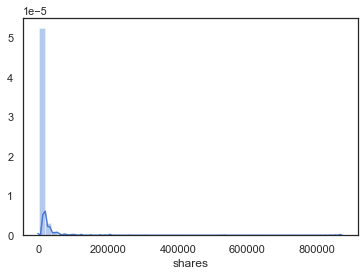

Skewness of Y: 20.346116262432247


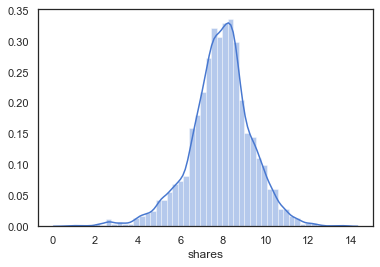

Skewness of Y: -0.434280773622946
False


In [33]:
# Loading the dataset
train_data = pd.read_csv('./data/Train.csv', header=0)
test_data = pd.read_csv('./data/Test.csv', header=0)
submit_data = pd.read_csv('./data/sample_submission.csv', header=0)

view_details(train_data)
view_details(submit_data)

# Exploratory Data Analysis
X = train_data.iloc[:, :-1]
Y = train_data.iloc[:, -1]
print(X.shape, X.columns)

# Plot the target variable
kde_plot(Y)

# finding skewness in the data
y_skew = skew(Y)
print(f"Skewness of Y: {y_skew}")

# Apply log transformation
y_log_values = np.log1p(Y)

kde_plot(y_log_values)
print(f"Skewness of Y: {skew(y_log_values)}")

# Checking null or missing values
print(train_data.isnull().sum().any())

In [98]:
# Checking duplicates
train_duplicates = train_data[train_data.duplicated()]
test_duplicates = test_data[test_data.duplicated()]

In [85]:
# Checking Multicollinearity
good_cols = compute_mulcol_score(X, 5)

# features = compute_mulcol_score(X[good_cols], 5)
print(good_cols)

['n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'kw_min_min', 'kw_min_max', 'kw_min_avg', 'min_positive_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_sentiment_polarity']


In [86]:
features = good_cols

# features.append('shares')

print(features)
train_data[features]


['n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'kw_min_min', 'kw_min_max', 'kw_min_avg', 'min_positive_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_sentiment_polarity']


,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_socmed,kw_min_min,kw_min_max,kw_min_avg,min_positive_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_sentiment_polarity
0,286.0,6.0,4.0,2.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.000000,0.136364,0.000000,0.000000,0.000000,0.000000
1,96.0,4.0,3.0,10.0,1.0,0.0,0.0,0.0,217.0,4400.0,2042.608696,0.200000,-0.600000,1.000000,0.500000,0.500000
2,399.0,21.0,1.0,20.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.000000,0.100000,-0.100000,0.535714,0.285714,0.285714
3,1388.0,40.0,4.0,2.0,5.0,1.0,0.0,0.0,-1.0,0.0,0.000000,0.033333,-0.050000,1.000000,-0.500000,0.500000
4,499.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.000000,0.100000,-0.100000,0.650000,0.350000,0.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7923,260.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.136364,-0.100000,0.400000,-0.250000,0.250000
7924,277.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,217.0,0.0,0.000000,0.200000,-0.071429,0.500000,0.500000,0.500000
7925,299.0,8.0,6.0,1.0,0.0,0.0,0.0,0.0,4.0,2700.0,1655.500000,0.136364,-0.050000,0.200000,0.300000,0.300000
7926,449.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,4.0,9800.0,2079.143129,0.100000,-0.066667,0.266667,0.175000,0.175000


## Correlation

In [93]:
def find_correlation(dataframe):
    columns = dataframe.columns
    y = train_data['shares']
    col_dict = {}
    for col in columns:
        X = train_data[col].values
        
        r = np.round(pearsonr(X, y),2)
        
        if np.abs(r[1]) > 0.3:
            col_dict[col] = r
            
    return col_dict

high_corr_cols = find_correlation(train_data)

# for i in range(train_data.shape[1]-1):
#     feature = train_data.columns[i]
#     X = train_data[feature].values
#     y = train_data['shares']
#     r = np.round(pearsonr(X, y),2)
#     print(f"Feature {feature}: Pearson : {r}")

In [94]:
print(high_corr_cols.keys())

dict_keys(['n_unique_tokens', 'n_non_stop_words', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'kw_max_max', 'weekday_is_monday', 'weekday_is_wednesday', 'weekday_is_friday', 'weekday_is_saturday', 'LDA_01', 'global_rate_positive_words', 'max_positive_polarity', 'abs_title_subjectivity'])


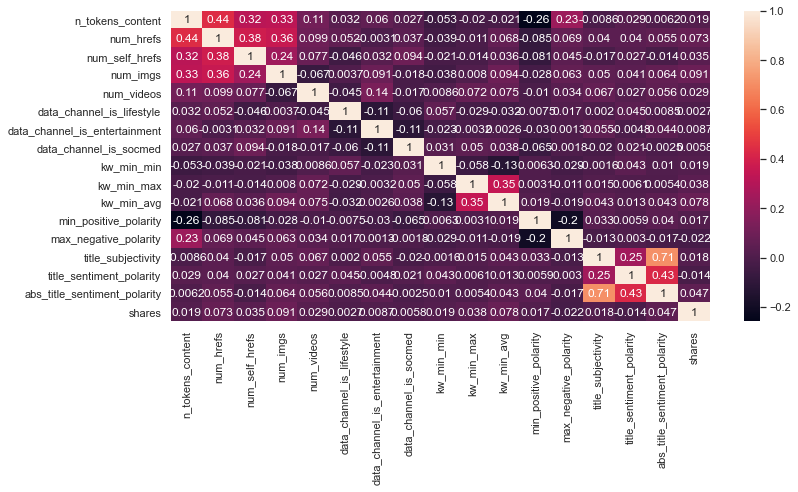

In [56]:
corr = train_data[features].corr()

correlation_plot(corr)

## Dimension Reduction

In [48]:
# features.remove('shares')

X = train_data[features]
y = train_data['shares']
X_test = test_data[features]

In [52]:
X.columns

Index(['n_tokens_title', 'n_tokens_content', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_socmed', 'kw_min_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg',
       'global_subjectivity', 'global_rate_positive_words',
       'min_positive_polarity', 'max_positive_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity'],
      dtype='object')

In [76]:
n_dim = 2

svd = TruncatedSVD(n_components=n_dim, n_iter=10, random_state=42).fit(X)

svd_train_matrix = svd.transform(X)

svd_test_matrix = svd.transform(X_test)

In [77]:
svd_train_df = pd.DataFrame(svd_train_matrix)

In [81]:
svd_train_df.head()

,0,1
0,928613.855220,89995.098459
1,89168.753878,11390.678826
2,887514.641067,-21533.089916
3,871779.698876,-64234.432308
4,872931.613130,-61106.233406


## Scale the features

In [13]:
selected_features = high_corr_cols.keys()
features = selected_features

In [87]:
# features.remove('shares')

X = train_data[features]
y = train_data['shares']
X_test = test_data[features]

scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)


In [88]:
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

## Model Building

In [78]:
lgb_params={
    'learning_rate': 0.1,
    'objective':'regression',
    'importance_type':'split',
    'metric':'rmse',
    'num_leaves': 31,
    "random_state":42,
    'max_depth': 6,
    "bagging_seed" : 42,
    "bagging_frequency" : 5,
    "reg_alpha":0.6,
    "reg_lambda":0.6,
    'min_child_samples': 20,
    'min_child_weight':0.6
}

xgb_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 0.6
}

In [100]:
lgbm = LGBMRegressor(**lgb_params, n_estimators=900)

xgb = XGBRegressor(n_estimators=700)

In [101]:
K = 7
kfolds = KFold(n_splits=K, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(kfolds.split(X_scaled_df)):
    
    y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    X_train, X_valid = X_scaled_df.iloc[train_idx, :], X_scaled_df.iloc[test_idx, :]
    
    print( "\nFold ", i)
    
    print("-"* 20 + "LGBM Regression" + "-"* 20)
    lgbm.fit(X_train, y_train, 
             eval_metric='rmse',
             eval_set=[(X_valid,  y_valid)],
            early_stopping_rounds=20,
            verbose=100)
    
#     print("-"* 20 + "XGB Regression" + "-"* 20)
#     xgb.fit(X_train, y_train, 
#              eval_metric='rmse',
#              eval_set=[(X_valid, y_valid)],
#             early_stopping_rounds=20,
#             verbose=100)
    


Fold  0
--------------------LGBM Regression--------------------
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 17041.7

Fold  1
--------------------LGBM Regression--------------------
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 42805.4

Fold  2
--------------------LGBM Regression--------------------
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 13576.5

Fold  3
--------------------LGBM Regression--------------------
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 12834

Fold  4
--------------------LGBM Regression--------------------
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 31062.7

Fold  5
--------------------LGBM Regression-----------

In [ ]:
predictions = 

## Build a Ridge Model

In [55]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(normalize=True, cv=7, alphas=alphas, gcv_mode='svd')

ridge_reg = TransformedTargetRegressor(regressor= ridge_cv,
                                      func=np.log1p,
                                      inverse_func=np.expm1)

In [56]:
# ridge_reg.fit(X_scaled, y)
ridge_reg.fit(svd_train_matrix, y)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                             cv=7, gcv_mode='svd',
                                             normalize=True))

In [57]:
# prediction = ridge_reg.predict(X_test_scaled)
prediction = ridge_reg.predict(svd_test_matrix)

In [58]:
prediction

array([3002.04828102, 2897.3775641 , 2274.7886993 , ..., 2376.23100073,
       2097.02283374, 2559.38029681])

In [60]:
final_df = pd.DataFrame({'shares': prediction}, index=test_data.index)

# final_df['SalesInMillions'] = final_df.apply(lambda x: round(x, 6))
final_df.to_csv('./data/newspopular_ttr_svd_04.csv', float_format='%.1f', index=False)